Vicente Alejandro Lomelín Ibarra

A01175933

Data Analytics

June, 2022

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

from scipy.cluster.hierarchy import fcluster
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

# Google Mobility Report of Mexico (2020_MX_Region_Mobility_Report.csv) Analysis 

## Extract time series for each state and indicator

In [2]:
df = pd.read_csv('2020_MX_Region_Mobility_Report.csv')

In [3]:
df.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

In [4]:
df['sub_region_1'] = df['sub_region_1'].where(df['sub_region_1'].isnull() == False,'National')

In [5]:
df['sub_region_1'].unique()

array(['National', 'Aguascalientes', 'Baja California',
       'Baja California Sur', 'Campeche', 'Chiapas', 'Chihuahua',
       'Coahuila', 'Colima', 'Durango', 'Guanajuato', 'Guerrero',
       'Hidalgo', 'Jalisco', 'Mexico City', 'Michoacán', 'Morelos',
       'Nayarit', 'Nuevo Leon', 'Oaxaca', 'Puebla', 'Querétaro',
       'Quintana Roo', 'San Luis Potosi', 'Sinaloa', 'Sonora',
       'State of Mexico', 'Tabasco', 'Tamaulipas', 'Tlaxcala', 'Veracruz',
       'Yucatan', 'Zacatecas'], dtype=object)

In [6]:
# Number of date entries
len(df['date'].unique())

277

In [7]:
indicators = ['retail_and_recreation_percent_change_from_baseline',
              'grocery_and_pharmacy_percent_change_from_baseline',
             'parks_percent_change_from_baseline',
              'transit_stations_percent_change_from_baseline',
              'workplaces_percent_change_from_baseline',
              'residential_percent_change_from_baseline'
             ]

In [8]:
# States
df['sub_region_1'].unique()

array(['National', 'Aguascalientes', 'Baja California',
       'Baja California Sur', 'Campeche', 'Chiapas', 'Chihuahua',
       'Coahuila', 'Colima', 'Durango', 'Guanajuato', 'Guerrero',
       'Hidalgo', 'Jalisco', 'Mexico City', 'Michoacán', 'Morelos',
       'Nayarit', 'Nuevo Leon', 'Oaxaca', 'Puebla', 'Querétaro',
       'Quintana Roo', 'San Luis Potosi', 'Sinaloa', 'Sonora',
       'State of Mexico', 'Tabasco', 'Tamaulipas', 'Tlaxcala', 'Veracruz',
       'Yucatan', 'Zacatecas'], dtype=object)

In [9]:
# List of dates
dates = list(df['date'].unique())

In [10]:
# List of states in csv file
# Remove nan from list (national entries)
states = df['sub_region_1'].unique()
states = list(states)

In [11]:
#Extract the indicator timeseries from each state and store it in a dictionary.
# indicators_ts is a dictionary that contains all
# the time series of each state for each of the indicators found in the original file
indicators_ts = {}

for indicator in indicators:
    states_ts = {}
    for state in states:
        ts = df.groupby(['sub_region_1'])[indicator].get_group(state).values
        states_ts[state] = ts
    indicators_ts[indicator] = states_ts

In [12]:
# Desired indicator to be studied can be extracted from the indicators_ts dictionary.
print('Indicators timeseries: {}'.format(indicators_ts.keys()))
print()
# For this work, Workplace indicator is to be studied.
# This print shows that it contains the information from each state.
print('Workplace indicator timeseries items: {}'.format(indicators_ts['workplaces_percent_change_from_baseline'].keys()))

# Transform Residential indicator into pandas DataFrame
df_state_ts = pd.DataFrame.from_dict(indicators_ts['workplaces_percent_change_from_baseline'])


Indicators timeseries: dict_keys(['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline'])

Workplace indicator timeseries items: dict_keys(['National', 'Aguascalientes', 'Baja California', 'Baja California Sur', 'Campeche', 'Chiapas', 'Chihuahua', 'Coahuila', 'Colima', 'Durango', 'Guanajuato', 'Guerrero', 'Hidalgo', 'Jalisco', 'Mexico City', 'Michoacán', 'Morelos', 'Nayarit', 'Nuevo Leon', 'Oaxaca', 'Puebla', 'Querétaro', 'Quintana Roo', 'San Luis Potosi', 'Sinaloa', 'Sonora', 'State of Mexico', 'Tabasco', 'Tamaulipas', 'Tlaxcala', 'Veracruz', 'Yucatan', 'Zacatecas'])


In [13]:
# The timeseries of each state and the National timeseries from the Workplace indicator is now on a pandas DataFrame
df_state_ts['date'] = df['date'].unique()
df_state_ts = df_state_ts.set_index('date')
df_state_ts.head()

,National,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Coahuila,Colima,Durango,...,San Luis Potosi,Sinaloa,Sonora,State of Mexico,Tabasco,Tamaulipas,Tlaxcala,Veracruz,Yucatan,Zacatecas
date,,,,,,,,,,,,,,,,,,,,,
2020-02-15,3,4,3,3,5,2,3,2,2,4,...,3,3,3,4,5,4,5,4,5,2
2020-02-16,2,1,1,1,1,2,2,3,-1,2,...,2,2,2,2,3,3,3,2,1,2
2020-02-17,11,12,9,12,16,13,12,10,11,15,...,12,10,9,11,20,9,11,18,10,18
2020-02-18,9,10,10,11,10,14,11,7,12,12,...,7,7,8,10,19,8,10,13,10,13
2020-02-19,8,9,8,10,10,14,12,6,11,12,...,6,6,5,9,17,7,9,13,10,12


In [14]:
df_state_ts = df_state_ts.drop(['National'],axis = 1) # Drop National

In [15]:
df_state_ts.head()

,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Coahuila,Colima,Durango,Guanajuato,...,San Luis Potosi,Sinaloa,Sonora,State of Mexico,Tabasco,Tamaulipas,Tlaxcala,Veracruz,Yucatan,Zacatecas
date,,,,,,,,,,,,,,,,,,,,,
2020-02-15,4,3,3,5,2,3,2,2,4,4,...,3,3,3,4,5,4,5,4,5,2
2020-02-16,1,1,1,1,2,2,3,-1,2,2,...,2,2,2,2,3,3,3,2,1,2
2020-02-17,12,9,12,16,13,12,10,11,15,16,...,12,10,9,11,20,9,11,18,10,18
2020-02-18,10,10,11,10,14,11,7,12,12,9,...,7,7,8,10,19,8,10,13,10,13
2020-02-19,9,8,10,10,14,12,6,11,12,8,...,6,6,5,9,17,7,9,13,10,12


In [16]:
df_state_ts = df_state_ts.T

In [17]:
df_state_ts

date,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,...,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15,2020-11-16,2020-11-17
Aguascalientes,4,1,12,10,9,9,11,4,0,13,...,10,-23,-25,-25,-25,-23,0,11,-59,-28
Baja California,3,1,9,10,8,8,10,1,2,12,...,-5,-18,-19,-20,-20,-17,-2,2,-50,-19
Baja California Sur,3,1,12,11,10,11,13,3,0,12,...,-13,-26,-29,-26,-27,-21,-12,-9,-48,-28
Campeche,5,1,16,10,10,8,9,1,-1,-23,...,0,-30,-31,-31,-31,-25,-4,3,-52,-30
Chiapas,2,2,13,14,14,14,12,2,1,13,...,2,-23,-24,-23,-23,-19,1,8,-42,-22
Chihuahua,3,2,12,11,12,9,10,5,2,12,...,-38,-28,-30,-28,-30,-28,-46,-33,-51,-27
Coahuila,2,3,10,7,6,5,9,4,4,11,...,6,-22,-26,-25,-25,-21,-3,8,-52,-26
Colima,2,-1,11,12,11,10,12,2,0,11,...,0,-22,-23,-22,-22,-19,-5,4,-53,-22
Durango,4,2,15,12,12,11,14,5,1,15,...,-9,-29,-33,-31,-32,-28,-7,-6,-55,-32
Guanajuato,4,2,16,9,8,7,11,5,2,16,...,7,-16,-22,-21,-22,-18,1,8,-49,-23


## Mobility indicators (country level) relationships

   * Are they directly or indirectly related?
    
   * Which of them move similarly?


As a first step, a visual exploration of each of the indicators timeseries at a national level is performed.

In [18]:
# Get only national time series
national = {}

for key in indicators_ts.keys():
    national[key] = indicators_ts[key]['National']
print(national.keys())

national_df = pd.DataFrame.from_dict(national)

dict_keys(['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline'])


In [19]:
national_df['date'] = df['date'].unique()
national_df = national_df.set_index('date')

In [20]:
national_df = national_df.T

In [21]:
national_df

date,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,...,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15,2020-11-16,2020-11-17
retail_and_recreation_percent_change_from_baseline,6.0,7.0,2.0,0.0,0.0,0.0,-2.0,0.0,2.0,-2.0,...,-35.0,-28.0,-27.0,-27.0,-26.0,-24.0,-24.0,-23.0,-23.0,-26.0
grocery_and_pharmacy_percent_change_from_baseline,4.0,6.0,4.0,-1.0,0.0,-1.0,-2.0,0.0,1.0,0.0,...,-12.0,-6.0,-7.0,-6.0,-5.0,1.0,1.0,-3.0,0.0,-5.0
parks_percent_change_from_baseline,6.0,7.0,3.0,3.0,2.0,2.0,-1.0,7.0,8.0,6.0,...,-41.0,-41.0,-40.0,-40.0,-40.0,-38.0,-36.0,-32.0,-37.0,-40.0
transit_stations_percent_change_from_baseline,4.0,6.0,5.0,2.0,3.0,3.0,4.0,4.0,7.0,4.0,...,-28.0,-35.0,-36.0,-36.0,-35.0,-31.0,-21.0,-22.0,-44.0,-34.0
workplaces_percent_change_from_baseline,3.0,2.0,11.0,9.0,8.0,7.0,11.0,4.0,2.0,8.0,...,0.0,-27.0,-29.0,-29.0,-29.0,-24.0,-3.0,5.0,-54.0,-29.0
residential_percent_change_from_baseline,-1.0,-1.0,-2.0,-2.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,...,6.0,12.0,12.0,13.0,13.0,12.0,6.0,4.0,16.0,12.0


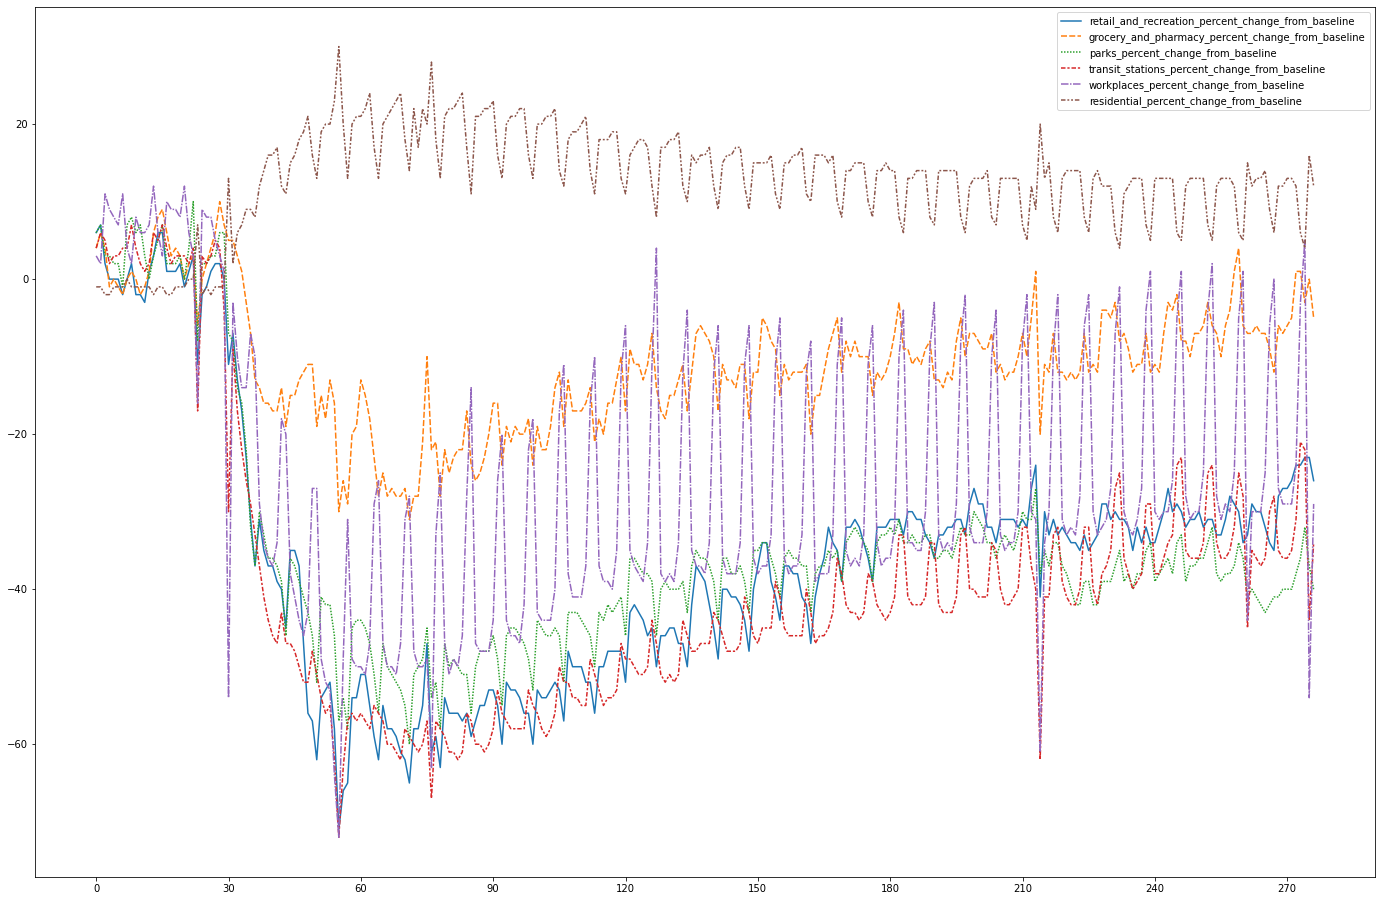

In [22]:
# Plot the Residential timeseries for all the states.

plt.figure(figsize=(24, 16))
fig = sns.lineplot(data=national_df.T.values)
fig.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.legend(national_df.index)

In [23]:
national_df.index

Index(['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

In [24]:
national_df.T['retail_and_recreation_percent_change_from_baseline']

date
2020-02-15     6.0
2020-02-16     7.0
2020-02-17     2.0
2020-02-18     0.0
2020-02-19     0.0
              ... 
2020-11-13   -24.0
2020-11-14   -24.0
2020-11-15   -23.0
2020-11-16   -23.0
2020-11-17   -26.0
Name: retail_and_recreation_percent_change_from_baseline, Length: 277, dtype: float64

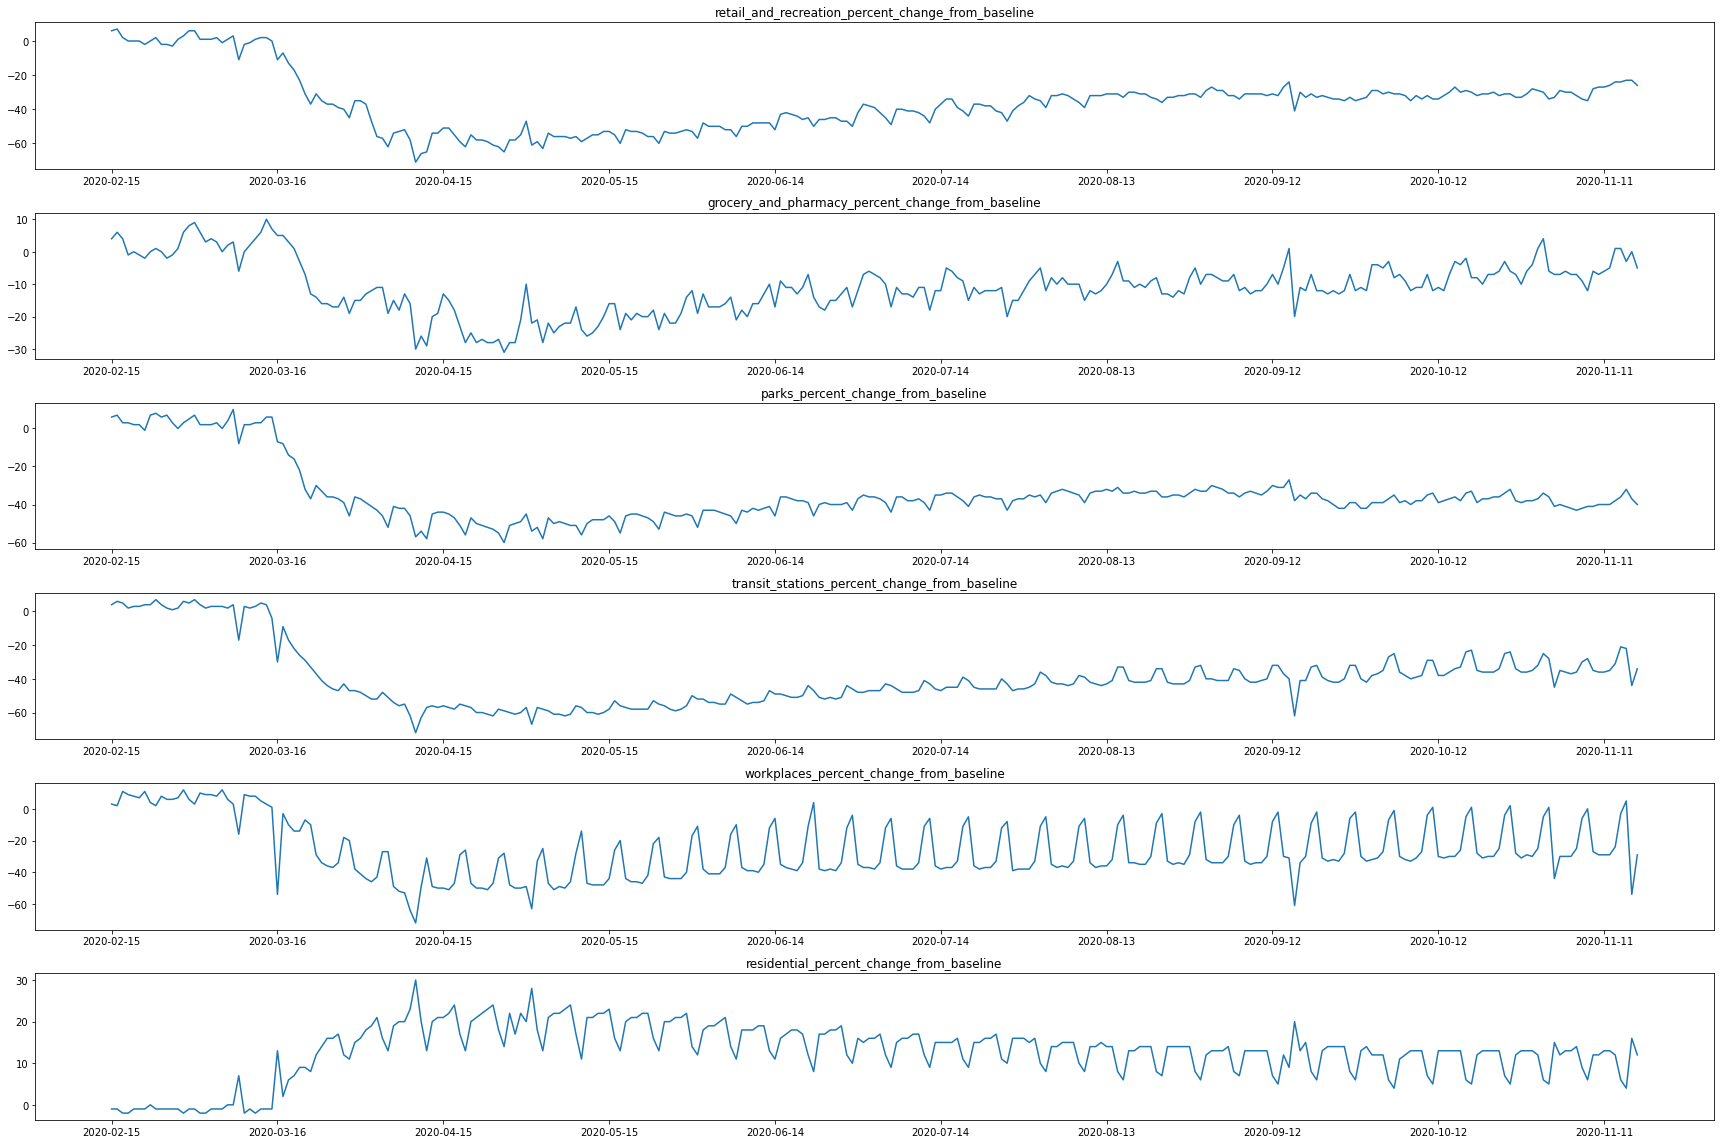

In [25]:

fig, axs = plt.subplots(6, figsize=(24, 16))

c = 0
for ind in national_df.index:
    axs[c].plot(national_df.T[ind])
    axs[c].set_title(ind)
    axs[c].xaxis.set_major_locator(plt.MaxNLocator(12))
    c += 1
    plt.tight_layout()
    

There are several similarities that can be observed between the different indicators. Similar behaviors can be observed between the retail, grocery and pharmacy, parks and residential indicators. Although not as prominent, a similarity can be observed between the transit and workplace indicators. Finally, oposite behaviors are evident between the workplace and residential indicators. The differences between worplace and residential indicators appear to be related. Decreases in the workplace is consistent with the stay at home policy that was adopted. In comparison with the initial values (begining of the pandemic), a decrease in the time at the workplace is observed, as well as an increase on the time at the residence. This is also related to the transit indicator. As the stay at home policy is adopted, commune time in transit is observed to decrease. An intresting observation can also be observed at entry date 210 (approximately), where work and transit show a prominent decrease, and the other indicators show an increase. This date might be a holiday, which would be consistent with these changes in the indicators.

## Mobility indicators in Mexico (country level) analysis and discussion.

### Trend and Seasonality

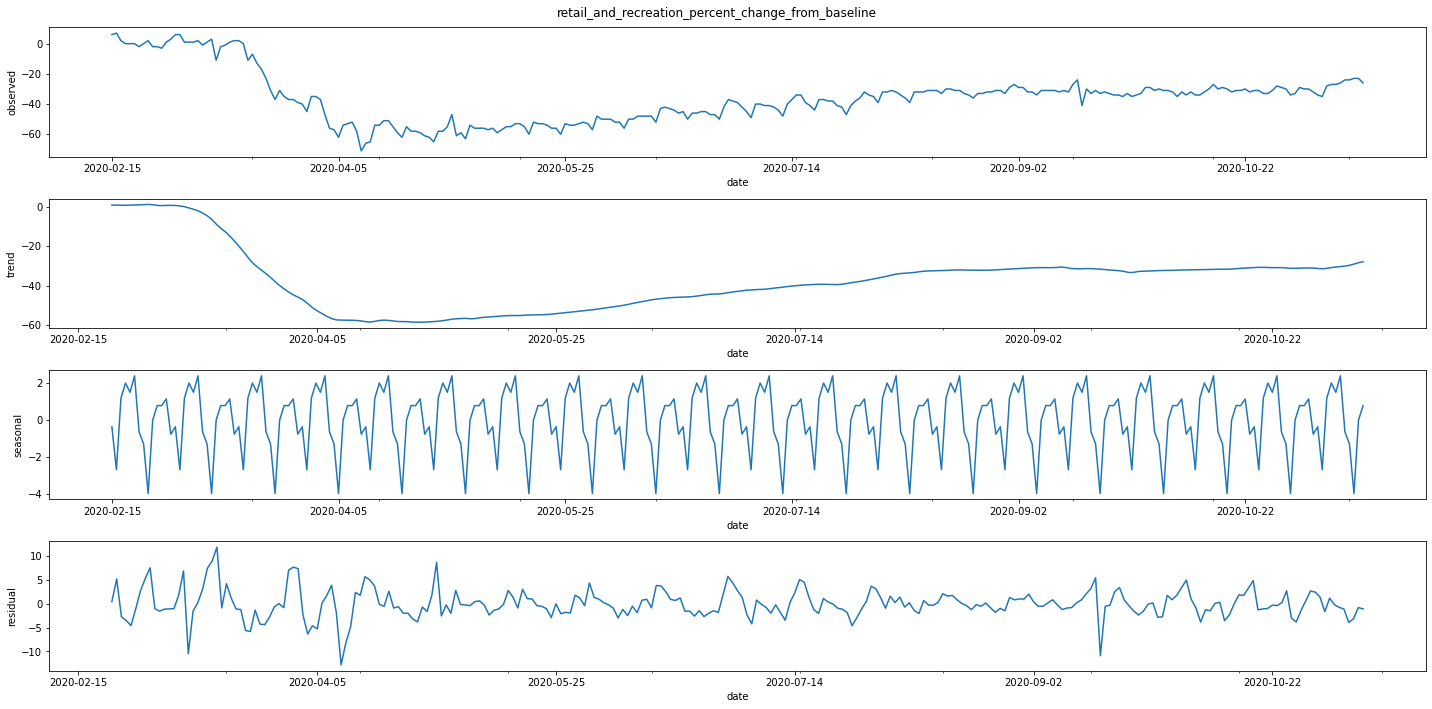

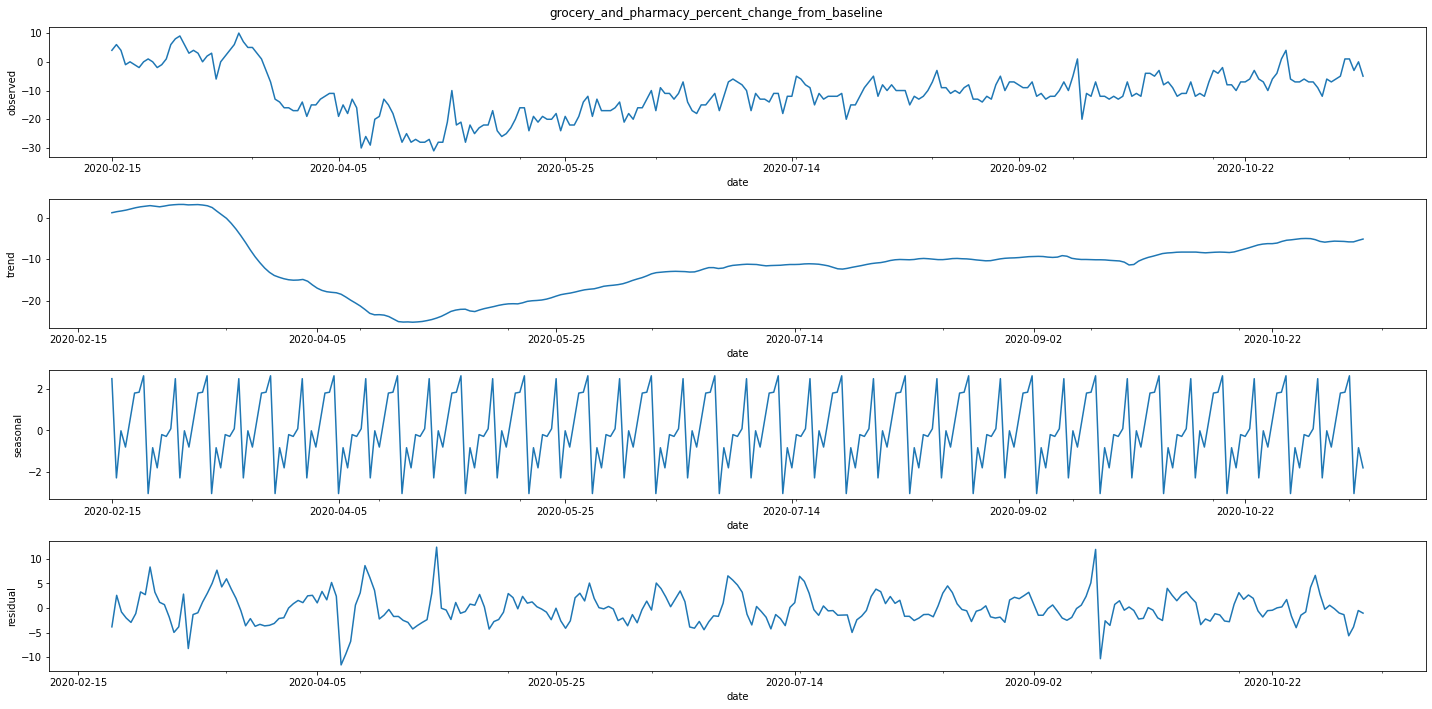

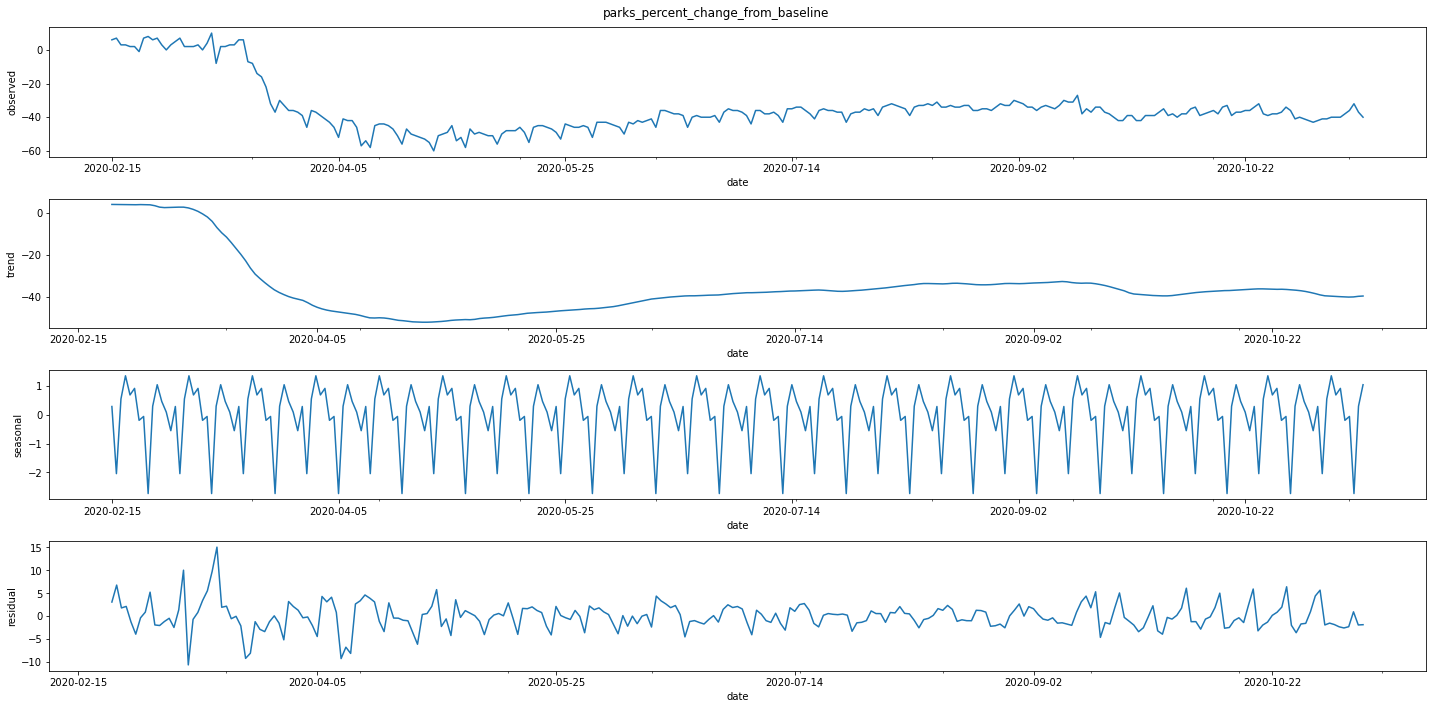

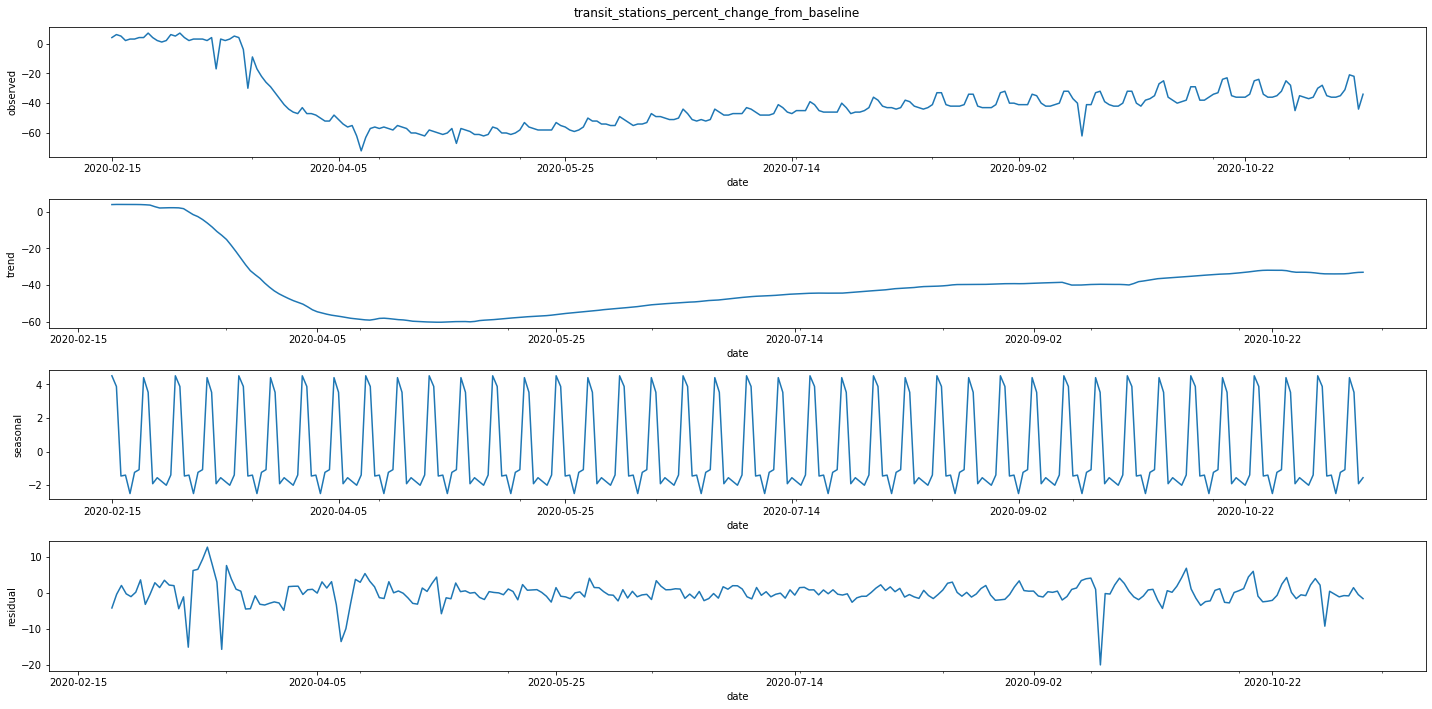

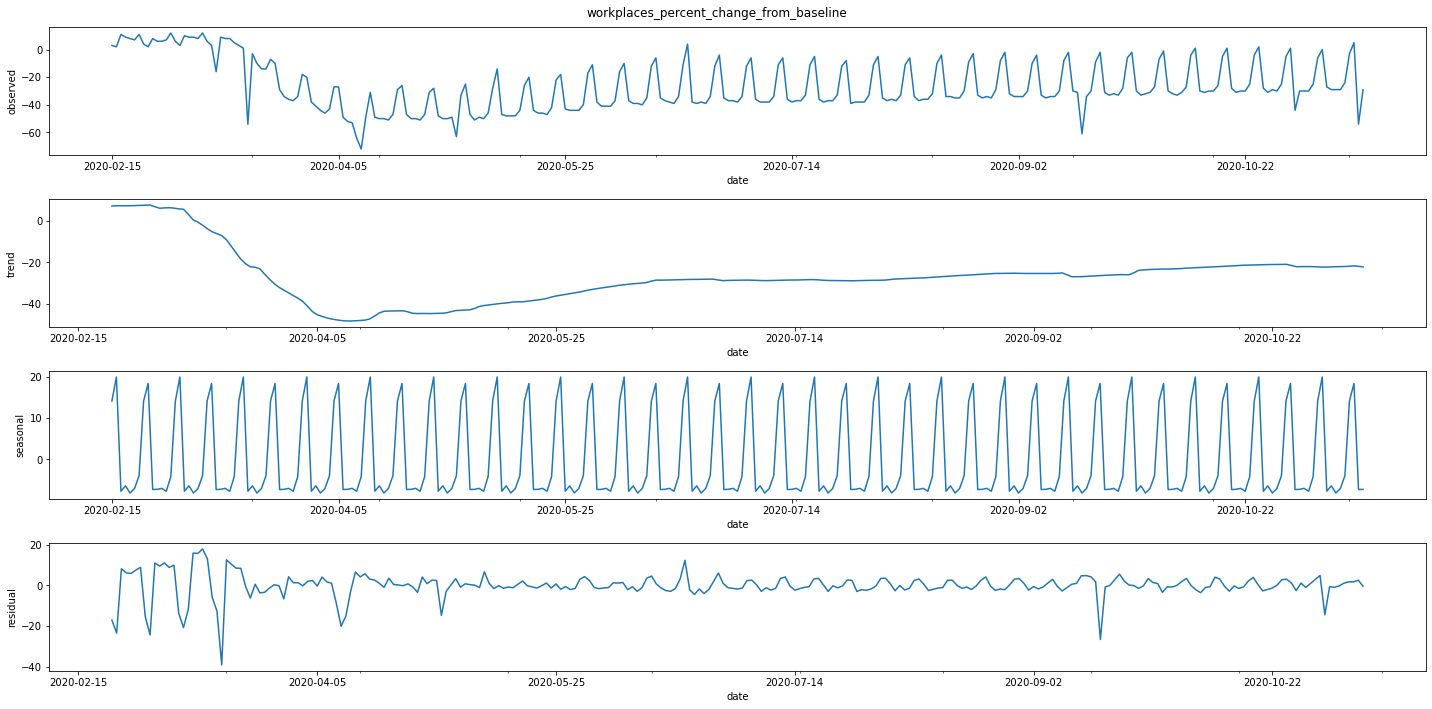

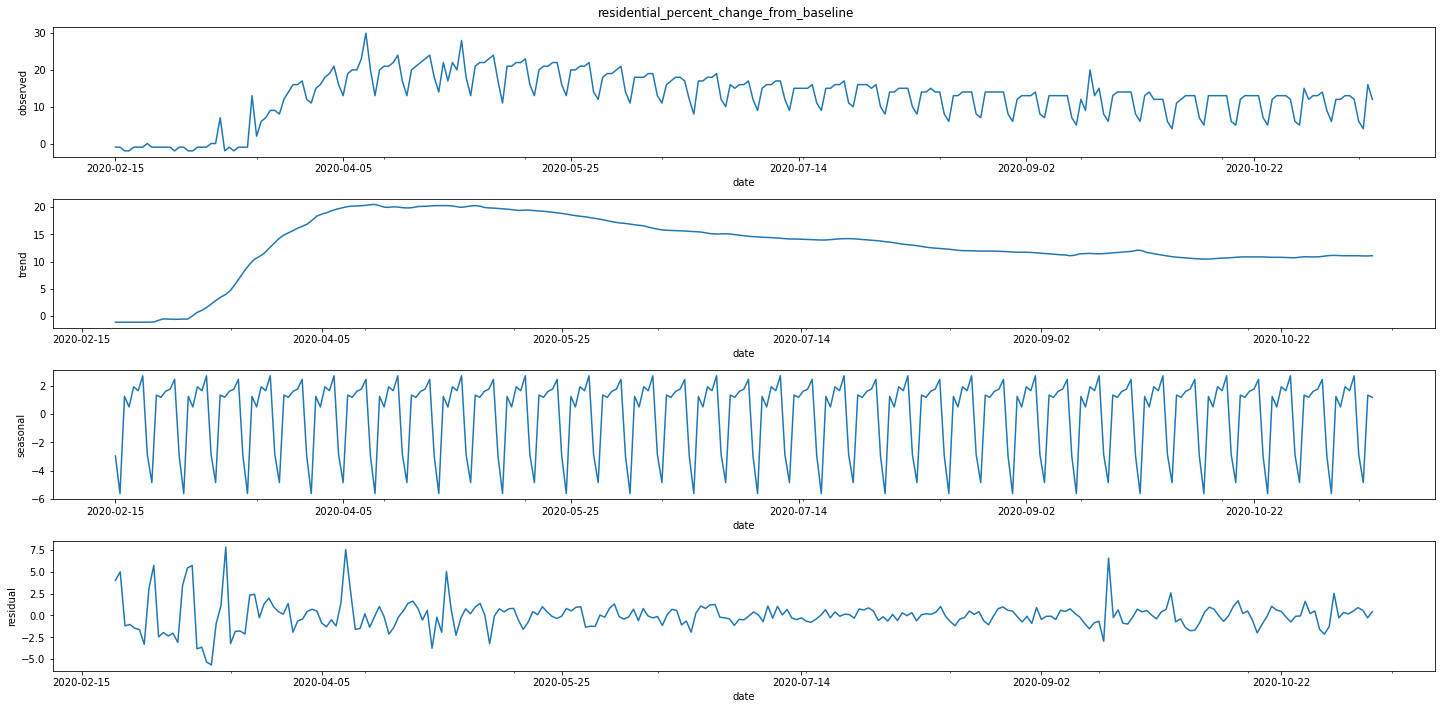

In [26]:
months = mdates.MonthLocator()  # mark months as ticks

for ind in national_df.index:
    decomposition = seasonal_decompose(national_df.T[ind], period = 14)
    observed = decomposition.observed
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    decomp_df = pd.DataFrame({"observed":observed, 'trend':trend, "seasonal":seasonal,"residual":residual})
    
    fig, axes = plt.subplots(nrows=4,ncols=1, figsize=(20, 10))
    for i, ax in enumerate(axes):
#         print()
        ax = decomp_df.iloc[:,i].plot(ax=ax)
        ax.xaxis.set_minor_locator(months)
        ax.set_ylabel(decomp_df.iloc[:,i].name)
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
        fig.suptitle(ind)
    plt.tight_layout()
    

*  Do you observe trend and seasonality? 

Given the previously presented results, there is a trend and seasonality that can be observed in every indicator. In the case of the workplace, parks, transit, grocery and retail, a downward trend is observed between the months of Feburary and April. After the month of April, the trends seems to remain constant. In the case of the residential indicator, an inverse behavior is observed, with an upward trend between the months of Feburary and April, and remaining somewhat constant after the month of April. In the case of seasonality, it appears to have a monthly frequency for every indicator. Nevertheless, the seasonality for each indicator appears to differ among each other.

### Stationarty

In [27]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(15).mean() #pd.rolling_mean(timeseries, window=12)
    rolstd = timeseries.rolling(15).std() #pd.rolling_std(timeseries, window=12)
    fig, ax = plt.subplots(figsize=(8, 6))
    #Plot rolling statistics:
    
#     print(axes.xaxis.set_minor_locator(months))
    
    ax.plot(timeseries.index, timeseries.values, color='blue',label='Original')
    
    ax.plot(rolmean, color='red', label='Rolling Mean')
    ax.plot(rolstd, color='black', label = 'Rolling Std')
    
#     ax.xaxis.set_minor_locator(mdates.MonthLocator())
    
    ax.legend(loc='best')
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    fig.suptitle('Rolling Mean & Standard Deviation')
    plt.title(ind)
    
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

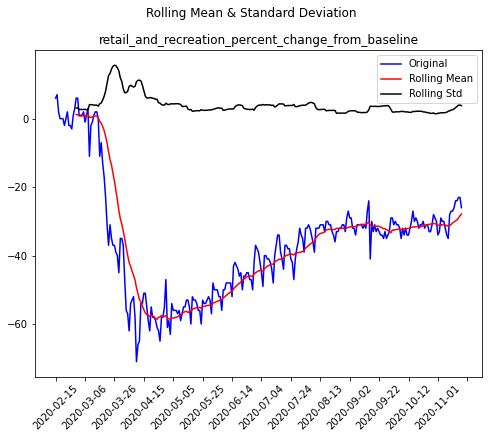

Results of Dickey-Fuller Test:
Test Statistic                  -3.117781
p-value                          0.025265
#Lags Used                      16.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


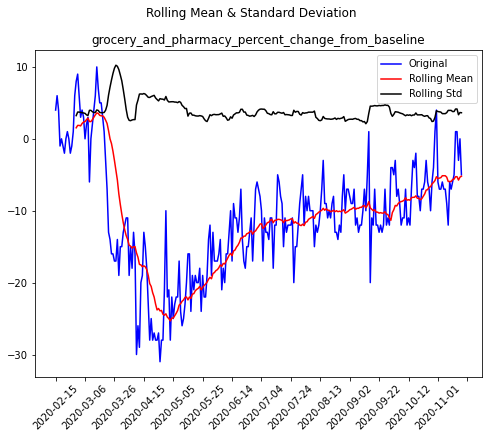

Results of Dickey-Fuller Test:
Test Statistic                  -2.146270
p-value                          0.226320
#Lags Used                      16.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


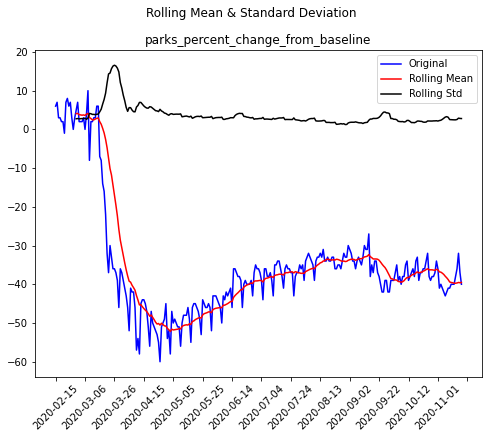

Results of Dickey-Fuller Test:
Test Statistic                  -3.543704
p-value                          0.006933
#Lags Used                      15.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64


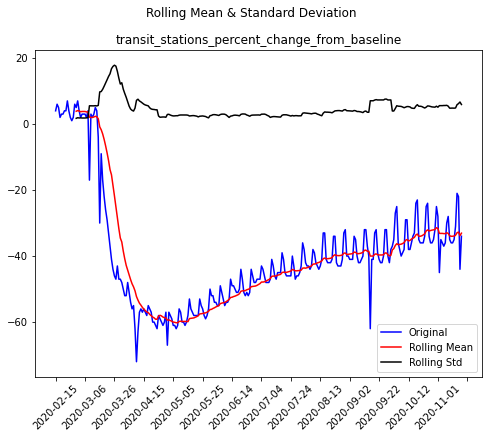

Results of Dickey-Fuller Test:
Test Statistic                  -3.588755
p-value                          0.005980
#Lags Used                      16.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


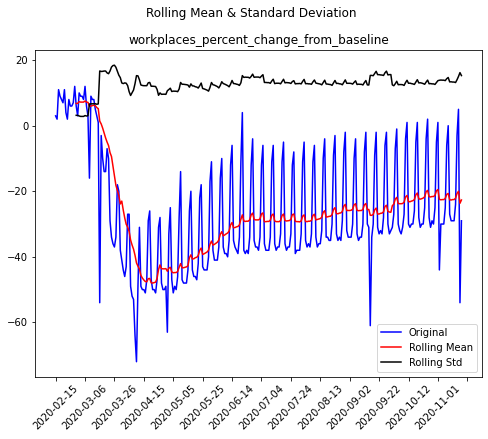

Results of Dickey-Fuller Test:
Test Statistic                  -3.284645
p-value                          0.015579
#Lags Used                      15.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64


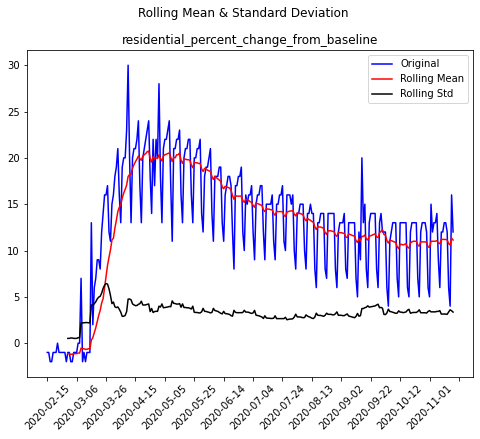

Results of Dickey-Fuller Test:
Test Statistic                  -3.161760
p-value                          0.022308
#Lags Used                      15.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64


In [28]:
for ind in national_df.index:
    test_stationarity(national_df.T[ind])

* Are they stationary?

According to the results obtained by the Dickey-Fuller test statistic, the **residential, workplace, transit, parks and retail** indicators from the dataset appear to be stationary, since their p-values are <= 0.05, rejecting the null hypothesis and indicating that the timeseries from these indicators are stationary. In contrast, the **grocery** indicator, although it provided a negative test statistic, the p-value was > 0.05, accepting the null hypothesis and indicating that the timeseries from this indicator is non-stationary. 



C:\Users\Vicente\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


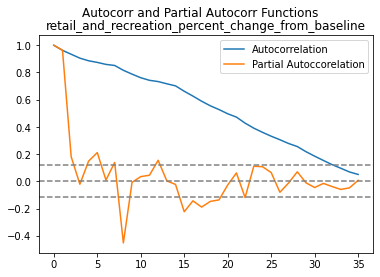

C:\Users\Vicente\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


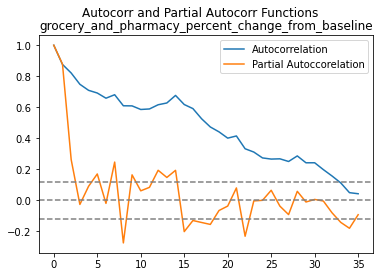

C:\Users\Vicente\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


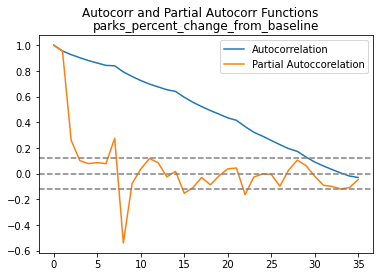

C:\Users\Vicente\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


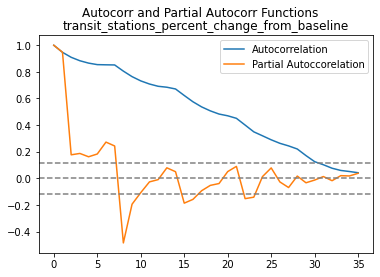

C:\Users\Vicente\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


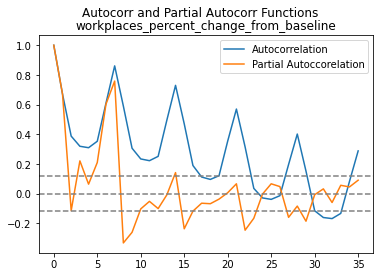

C:\Users\Vicente\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


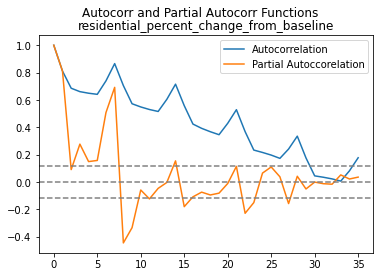

In [29]:
for ind in national_df.index:

    lag_acf = acf(national_df.T[ind], nlags=35)
    lag_pacf = pacf(national_df.T[ind], nlags=35, method='ols')

    plt.plot(lag_acf)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(national_df.T[ind])),linestyle='--',
                color='gray')
    plt.axhline(y=1.96/np.sqrt(len(national_df.T[ind])),linestyle='--',
                color='gray')
    plt.legend(['Autocorrelation', 'Partial Autoccorelation'])
    plt.suptitle('Autocorr and Partial Autocorr Functions')
    plt.title(ind)
    plt.show()

* Define 3 periods of time based on the observed characteristics and series data.

Given the observed characteristics and the data, and the obtained results from the Autocorrelation and Partial Autoccorelation Functions presented in the previous plots, a first time period that would be appropiate would be of approximately three weeks, for a 21 days period. The second time period considered is of 30 days. The last period of time that can be observed in all the indicators is of 7 days.

## 7 Day prediction model of the Workplaces indicator in Mexico (country level)

* Do you need to make a transformation for generating the model?

Given that the results obtained from the Dickey-Fuller test for the workplace indicator at national level indicated that the timeseries was stationary, no additional transformation was performed over the data of the indicator's timeseries.

* Train at least 3 predictive models.
* Document the characteristics of the best model, indicating its RMSE.
* Make a visualization of the best prediction.

AR, MA and ARIMA models were implemented to predict the last 7 days of the time series. The models were evaluated by calculating RMSE.

In [30]:
# Workplaces indicator
work_ts = national_df.T['workplaces_percent_change_from_baseline']
work_ts.head()

date
2020-02-15     3.0
2020-02-16     2.0
2020-02-17    11.0
2020-02-18     9.0
2020-02-19     8.0
Name: workplaces_percent_change_from_baseline, dtype: float64

In [31]:
# split last 7 days to perform prediction

work_ts_train = work_ts[:-7]

work_ts_test = work_ts[-7:]

print('Last 7 days: {}'.format(list(work_ts_test.index)))

Last 7 days: ['2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14', '2020-11-15', '2020-11-16', '2020-11-17']


In [32]:
# AR model

model = ARIMA(work_ts_train,order=(2,1,0))
fitAR = model.fit()
AR_pred = fitAR.predict(start=len(work_ts_train), end=len(work_ts_train)+len(work_ts_test)-1, dynamic=False)

for i in range(len(AR_pred)):
    print('predicted=%4f, expected=%4f' % (AR_pred[i], work_ts_test[i]))

predicted=9.436709, expected=-29.000000
predicted=-0.005922, expected=-29.000000
predicted=-3.445261, expected=-24.000000
predicted=0.068455, expected=-3.000000
predicted=1.062322, expected=5.000000
predicted=-0.228018, expected=-54.000000
predicted=-0.498720, expected=-29.000000


C:\Users\Vicente\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Vicente\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D

In [33]:
rmse = np.sqrt(mean_squared_error(work_ts_test,AR_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 30.400


In [34]:
# MA model
model = ARIMA(work_ts_train,order=(0,1,2))
fitMA = model.fit()
MA_pred = fitMA.predict(start=len(work_ts_train), end=len(work_ts_train)+len(work_ts_test)-1, dynamic=False)

for i in range(len(MA_pred)):
    print('predicted=%4f, expected=%4f' % (MA_pred[i], work_ts_test[i]))

predicted=6.598902, expected=-29.000000
predicted=-0.007773, expected=-29.000000
predicted=-0.106545, expected=-24.000000
predicted=-0.106545, expected=-3.000000
predicted=-0.106545, expected=5.000000
predicted=-0.106545, expected=-54.000000
predicted=-0.106545, expected=-29.000000


C:\Users\Vicente\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Vicente\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D

In [35]:
rmse = np.sqrt(mean_squared_error(work_ts_test,MA_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 30.361


In [36]:
# ARIMA model
# MA model
model = ARIMA(work_ts_train,order=(2,1,2))
fitARMA = model.fit()
ARMA_pred = fitARMA.predict(start=len(work_ts_train), end=len(work_ts_train)+len(work_ts_test)-1, dynamic=False)

for i in range(len(ARMA_pred)):
    print('predicted=%4f, expected=%4f' % (ARMA_pred[i], work_ts_test[i]))

predicted=-2.843000, expected=-29.000000
predicted=6.459968, expected=-29.000000
predicted=8.938083, expected=-24.000000
predicted=4.740314, expected=-3.000000
predicted=-1.574917, expected=5.000000
predicted=-5.240620, expected=-54.000000
predicted=-4.512936, expected=-29.000000


C:\Users\Vicente\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Vicente\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D

In [37]:
rmse_ARMA = np.sqrt(mean_squared_error(work_ts_test,ARMA_pred))
print('Test RMSE: %.3f' % rmse_ARMA)

Test RMSE: 29.536


The best results were obtained with the ARIMA model with (p,d,q) values of (2,1,2), with an RMSE of 29.536. Which presents the following coefficients.

In [38]:
print('Coefficients: %s' % fitARMA.params)

Coefficients: const                                             -0.098906
ar.L1.D.workplaces_percent_change_from_baseline    1.069814
ar.L2.D.workplaces_percent_change_from_baseline   -0.736205
ma.L1.D.workplaces_percent_change_from_baseline   -1.642436
ma.L2.D.workplaces_percent_change_from_baseline    0.823608
dtype: float64


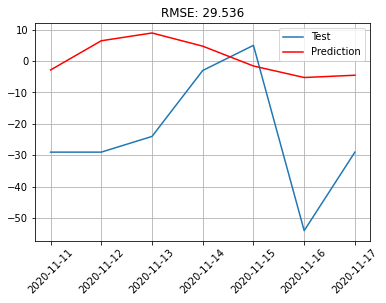

In [44]:
# Visualization of the best prediction
plt.plot(work_ts_test)
plt.plot(ARMA_pred.values, c = 'r')
plt.legend(['Test', 'Prediction'])
plt.xticks(rotation = 45)
plt.title('RMSE: %.3f' % rmse_ARMA)
plt.grid()
plt.show()

## Workplaces indicator similarity behavior

* Document the characteristics of the algorithm you used.

To observe the similar behavior between states of the workplace indicator, different clustering algorithms were used.
The implemented algorithms were:

* Ward with euclidean distance
* Single method with pearson correlation
* Single method with DTW

In [45]:
# Clustering functions as were seen in class.
def print_clusters(timeSeries, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')
    print(results)

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        plt.figure(figsize=(16, 10))
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            timeSeries.T.iloc[:,cluster_indeces].plot(rot = 45)
        plt.show()
        
def spearman_metric(x, y):
    r = stats.spearmanr(x, y)[0]
    return 1 - r # correlation to distance: range 0 to 2


def dtw(x, y):
    distance, path = fastdtw(x, y, dist=euclidean)
    return distance

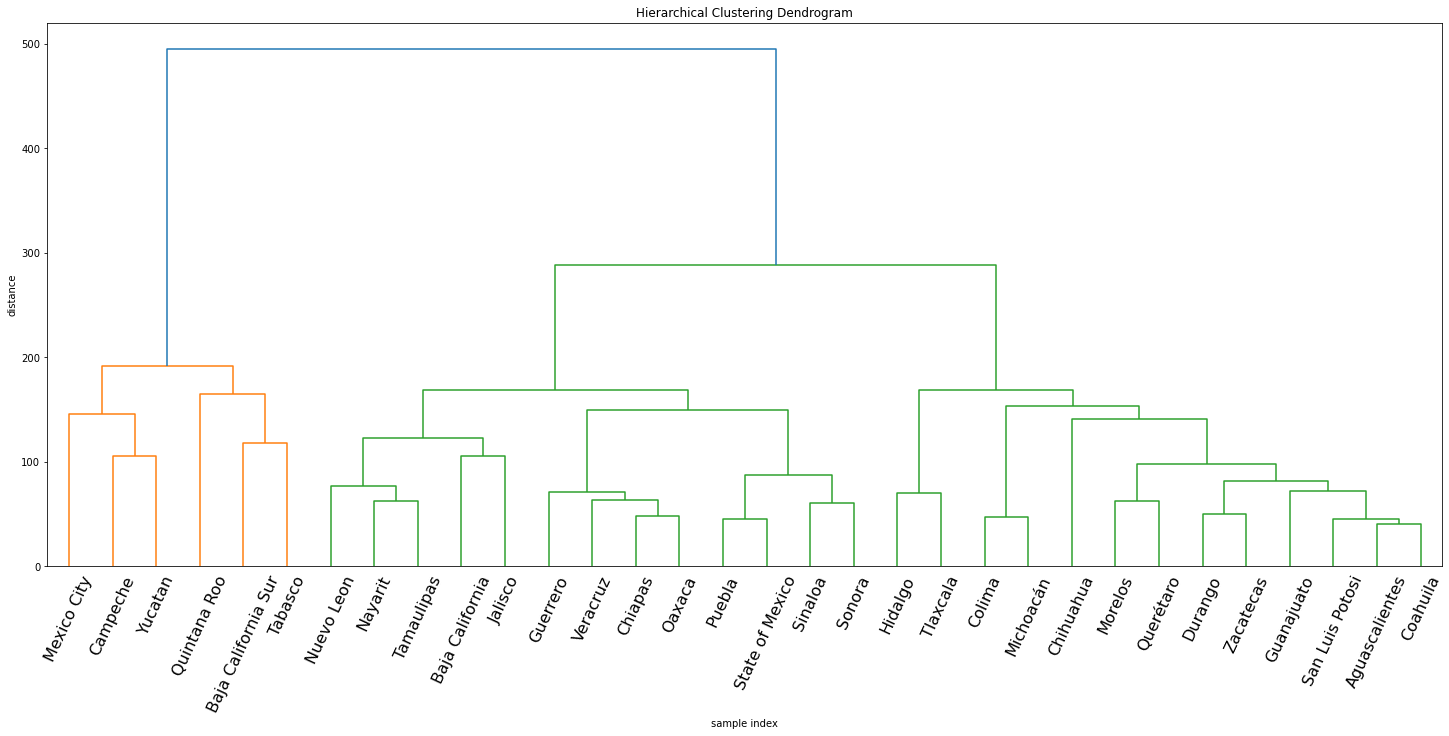

In [46]:
Z = hac.ward(df_state_ts.values)

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=65.,  # rotates the x axis labels
    leaf_font_size=16., 
    labels = df_state_ts.index  # font size for the x axis labels
)
plt.show()

[5 3 2 1 3 5 5 5 5 5 3 4 3 1 5 5 3 3 3 3 5 2 5 3 3 3 2 3 4 3 1 5]
Cluster 5 number of entries 11


<Figure size 1152x720 with 0 Axes>

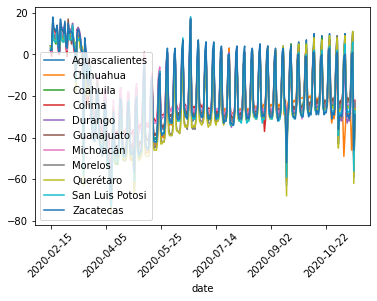

Cluster 3 number of entries 13


<Figure size 1152x720 with 0 Axes>

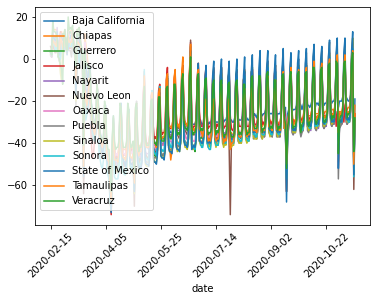

Cluster 2 number of entries 3


<Figure size 1152x720 with 0 Axes>

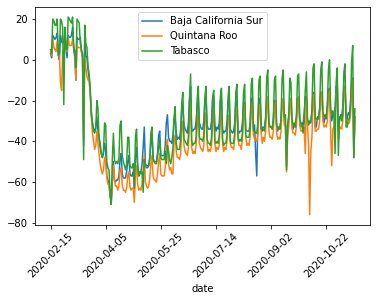

Cluster 1 number of entries 3


<Figure size 1152x720 with 0 Axes>

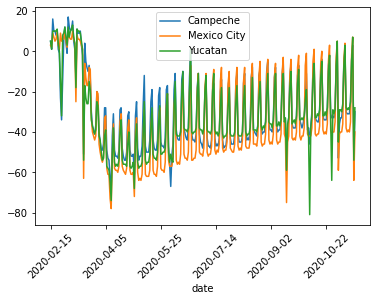

Cluster 4 number of entries 2


<Figure size 1152x720 with 0 Axes>

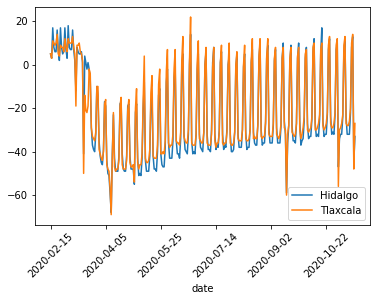

In [47]:
print_clusters(df_state_ts, Z, 5, plot=True)

With the Ward with euclidean distance as the metric, 5 groups of states were found to have similarities in the workplace. With the first group containing 11 states, the second state containing 13 states, the third and fourth group containing three states and the last group containing two states. The grouping was done with a cutoff of approximately at 190.

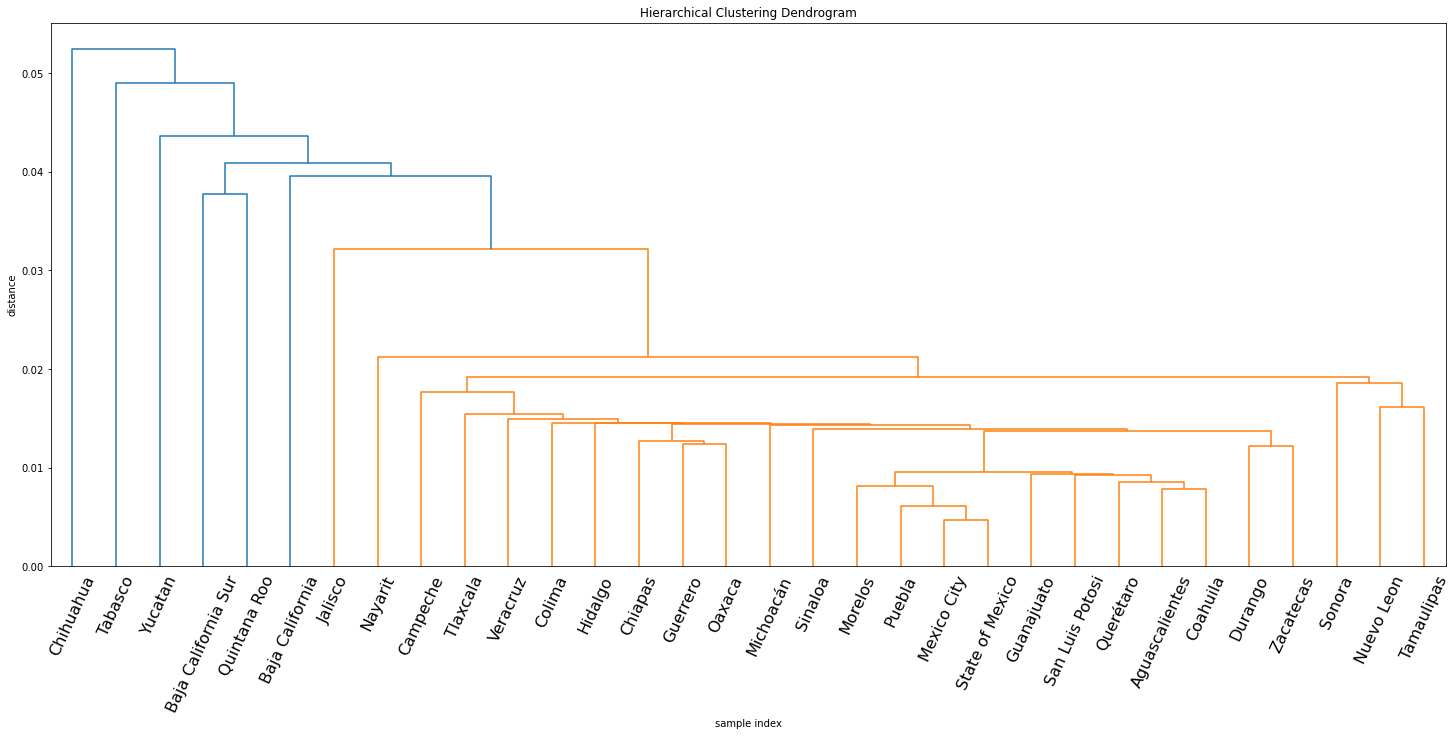

In [48]:
Z = hac.linkage(df_state_ts.values, method='single', metric='correlation')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=65.,  # rotates the x axis labels
    leaf_font_size=16., 
    labels = df_state_ts.index  # font size for the x axis labels
)
plt.show()

[2 2 1 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 4 2 2 2 3 2]
Cluster 2 number of entries 27


<Figure size 1152x720 with 0 Axes>

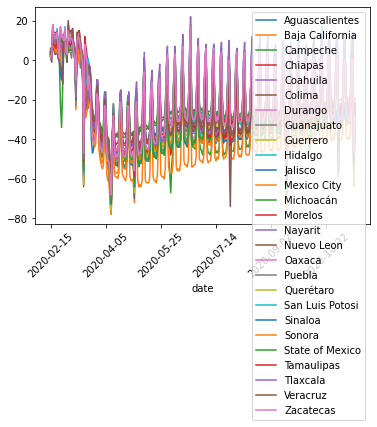

Cluster 1 number of entries 2


<Figure size 1152x720 with 0 Axes>

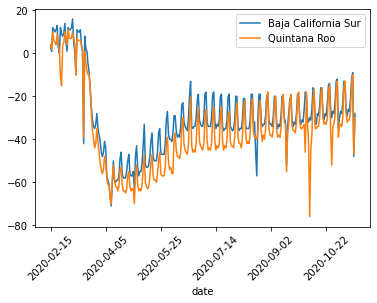

Cluster 5 number of entries 1


<Figure size 1152x720 with 0 Axes>

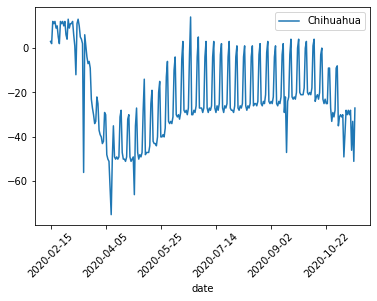

Cluster 4 number of entries 1


<Figure size 1152x720 with 0 Axes>

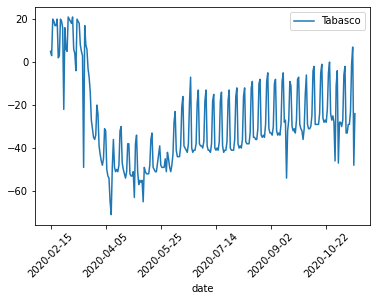

Cluster 3 number of entries 1


<Figure size 1152x720 with 0 Axes>

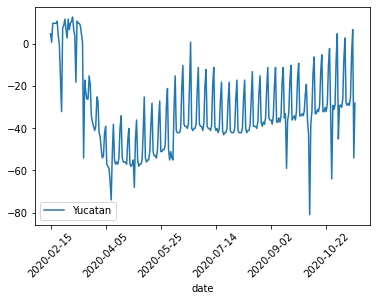

In [49]:
print_clusters(df_state_ts, Z, 5, plot=True)

With the single method using pearson correlation as a metric, 5 groups were found. 
The first group contains 27 of the states, a single group with two states, and the last three states with a single state. This results indicate that the states of Caja California Sur, Quintana Roo, Chihuahua, Tabasco and Yucatan are the states that present the greatest differences. The cutoff to creates this groups was of apporimately of 0.04.

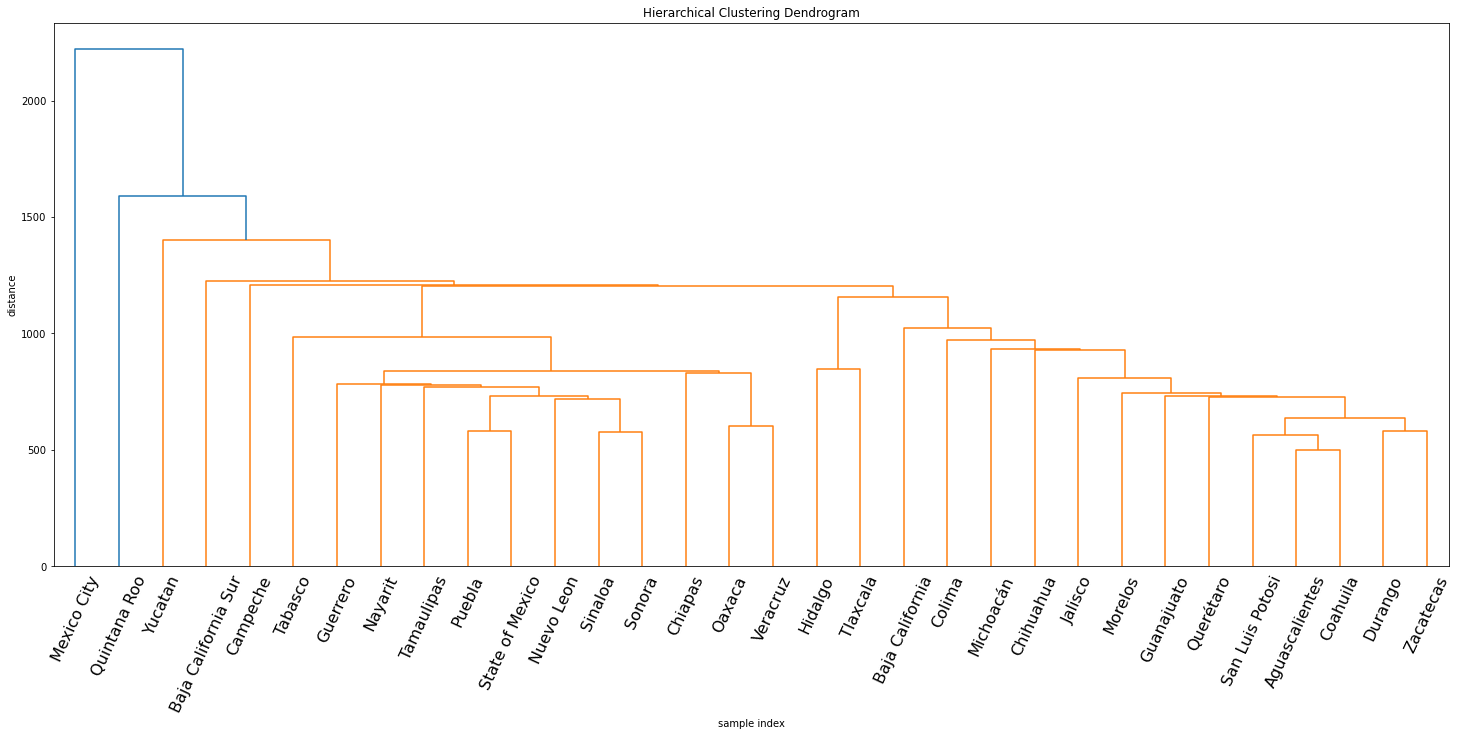

In [50]:
# DTW
Z = hac.linkage(df_state_ts.values,  method='single', metric=dtw)

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=65.,  # rotates the x axis labels
    leaf_font_size=16., # font size for the x axis labels
    labels = df_state_ts.index  # State labels
)
plt.show()

[1 1 2 1 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 3 1]
Cluster 1 number of entries 28


<Figure size 1152x720 with 0 Axes>

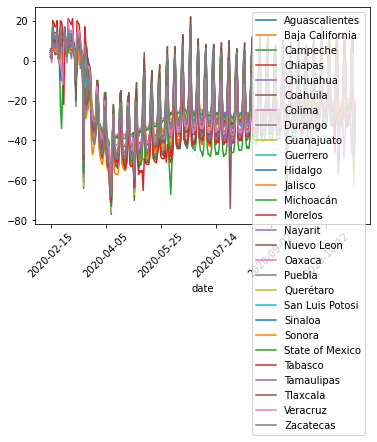

Cluster 2 number of entries 1


<Figure size 1152x720 with 0 Axes>

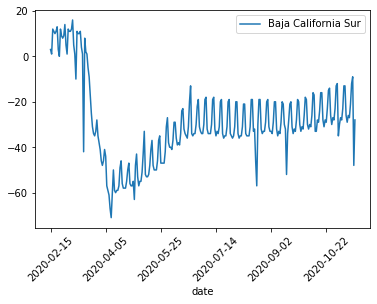

Cluster 5 number of entries 1


<Figure size 1152x720 with 0 Axes>

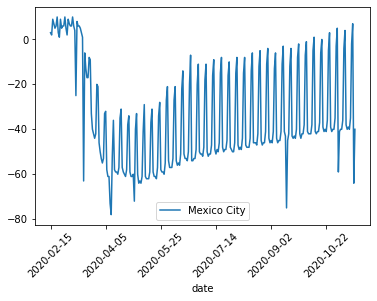

Cluster 4 number of entries 1


<Figure size 1152x720 with 0 Axes>

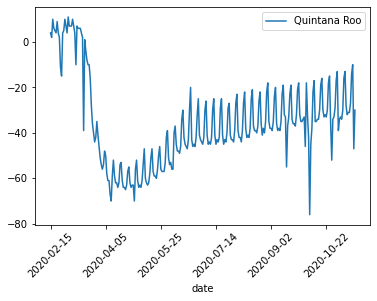

Cluster 3 number of entries 1


<Figure size 1152x720 with 0 Axes>

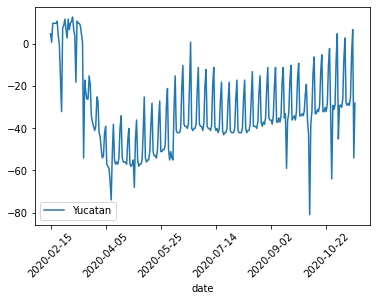

In [51]:
print_clusters(df_state_ts, Z, 5, plot=True)

# Conclusions

Within the recollected data in Google's Mobility report, information that describes the mobility behavior of the countries citizens is observed. The report contains information from the mobility behavior at both national and state level. Exploring the data, different indicators of the country's mobility behavious can be abalyzed and evaluated as a time series. Most of the indicators appeard to be stationary. The presence of stationarity in the indicators' timeseries allow to build predicting models on the behavior of the mobility. Trend and seasonality are factors that can also be observed in the data. These parameters provides additional insight upon the mobility behavior during the pandemic period. Using the Workplace indicator, three predictive models were able to implemented without modifying the data from the time series to predict the last 7 days. The best RMSE score was obtained with the ARMA model, with a score of 29.536. Although the comparison of the predicted values against the real values did not present great similarity, an estimation of the progression of the mobility's behavior can be obtained as a reference for future events. The information of the Mobility report proved valuable information that can be used to study the human behavior during the pandemic period that was lived. The ifnromation that could be obtained from this data could prove to be useful for future events that forces the citizend into a similar situation.